In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

import shap

In [3]:
# plt.rcParams['font.family'] = "MS Gothic"
warnings.simplefilter('ignore')

In [4]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
fix_all_seeds(0)

In [5]:
# Config
SAVE_SUB = False
SAVE_SUB_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/sub_20230225")
SUB_FILE_NAME = "val4_mod1"

# データ読み込み

In [6]:
train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/train.pkl")
test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/test.pkl")
sub = pd.read_csv("/content/drive/MyDrive/Kaggle/BlueCarbon/raw/submit_example.csv")
train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13


In [7]:
sub.head(2)

,0,0.47
0,1,0.68
1,2,0.25


# 前処理

In [8]:
# 被度文献データ、海洋環境要因データ、landsat使用
# YMDは使わない
cols_base = train.columns.to_list()[:25]
# cols_sentinel = train.columns.to_list()[88:313]
# cols_sentinel = [col for col in cols_sentinel if "MED" in col]
cols_use = cols_base # + cols_sentinel

cols_remove = ["YMD"]
cols_use = [col for col in cols_use if not col in cols_remove]
cols_use

['lat',
 'lon',
 'area',
 'year',
 'month',
 'cover',
 'depth_original',
 'cliff_length',
 'aicial_length',
 'beach_length',
 'coast_length',
 'coastal_dist',
 'cold_sst',
 'depth',
 'fetch',
 'hist_cold_sst',
 'hist_warm_sst',
 'river_area',
 'river_dist',
 'Salinity_annual',
 'warm_sst',
 'sst_annual',
 'sst_ymd',
 'sst_diff']

In [9]:
train = train[cols_use]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lat              14140 non-null  float32
 1   lon              14140 non-null  float32
 2   area             14140 non-null  float32
 3   year             14140 non-null  float32
 4   month            14140 non-null  float32
 5   cover            14140 non-null  float32
 6   depth_original   4419 non-null   float32
 7   cliff_length     13849 non-null  float32
 8   aicial_length    13849 non-null  float32
 9   beach_length     13849 non-null  float32
 10  coast_length     13849 non-null  float32
 11  coastal_dist     13849 non-null  float32
 12  cold_sst         13849 non-null  float32
 13  depth            13849 non-null  float32
 14  fetch            13849 non-null  float32
 15  hist_cold_sst    13849 non-null  float32
 16  hist_warm_sst    13849 non-null  float32
 17  river_area  

In [10]:
features = [col for col in cols_use if col != "cover"]
print("特徴量の数：", len(features))

特徴量の数： 23


# CV

shap:  

https://data-analysis-stats.jp/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92%E8%A7%A3%E9%87%88%E3%81%99%E3%82%8Bshap/

In [11]:
train_date = train[["year", "month"]].copy()

def convert_int_into_str(x):
    x_str = str(int(x))
    if len(x_str)==1:
        return "0" + x_str
    return x_str

train_date["month_str"] = train_date["month"].apply(convert_int_into_str)
train_date["year_month"] = (train_date["year"].astype(int).astype(str) + train_date["month_str"]).astype(int)
train_date.head()

,year,month,month_str,year_month
0,2011.0,9.0,09,201109
1,2009.0,7.0,07,200907
2,2009.0,10.0,10,200910
3,2009.0,1.0,01,200901
4,2009.0,1.0,01,200901


In [12]:
year_month = train_date["year_month"]
cv = []

val_idx1 = (year_month >= 200901)&(year_month <200907)
train_idx1 = ~val_idx1
cv.append([train_idx1, val_idx1])

val_idx2 = (year_month >= 200910)&(year_month <200912)
train_idx2 = ~val_idx2
cv.append([train_idx2, val_idx2])

val_idx3 = (year_month >= 201006)&(year_month <201009)
train_idx3 = ~val_idx3
cv.append([train_idx3, val_idx3])

val_idx4 = (year_month >= 201010)&(year_month <201101)
train_idx4 = ~val_idx4
cv.append([train_idx4, val_idx4])

val_idx5 = (year_month >= 201909)&(year_month <201910)
train_idx5 = ~val_idx5
cv.append([train_idx5, val_idx5])

In [13]:
def my_cross_val_predict(df, df_test, y_name=None, params=None, features=None, cv=None, eval_by_shap=True):
    # CVの結果を集約する変数
    results_rmse = []
    dict_learning_rate = {}
    fi_df = pd.DataFrame()
    fi_df['features'] = features

    X = df[features].values
    y = df[y_name].values

    # 同時にtestデータも予測する
    X_test = df_test[features].values
    y_pred_test_mean = np.zeros(len(X_test))

    for i, (train_idx, val_idx) in enumerate(cv):
        print("###"*10)
        print(f"● CV{i}")
        print("###"*10)
        X_train = X[train_idx, :]
        y_train = y[train_idx]
        X_val = X[val_idx, :]
        y_val = y[val_idx]

        train_dataset = lgb.Dataset(X_train,
                                    y_train,
                                    feature_name=features,)
        val_dataset = lgb.Dataset(X_val,
                                  y_val,
                                  feature_name=features,)
        
        evals_result = {}
        callbacks = [
            # lgb.log_evaluation(100),
            # lgb.early_stopping(500),
            lgb.record_evaluation(evals_result)
        ]

        # モデル作成
        model = lgb.train(params=params,
                          train_set=train_dataset,
                          valid_sets=[val_dataset],
                          callbacks=callbacks,
                          verbose_eval=500,)
        # valデータ予測
        y_pred = model.predict(X_val)
        y_pred[y_pred<0] = 0
        y_pred[y_pred>1] = 1
        print(np.average(y_pred))
        # testデータ予測
        y_pred_test = model.predict(X_test)
        # この処理は最後にやる
        # y_pred_test[y_pred_test<0] = 0
        # y_pred_test[y_pred_test>1] = 1
        y_pred_test_mean += (y_pred_test / len(cv))

        # RMSE計算
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        results_rmse.append(rmse)

        # 予測結果の可視化
        fig, ax = plt.subplots()
        ax.grid(alpha=0.2)
        ax.scatter(y_pred, y_val, s=2)
        ax.set_xlabel("Pred")
        ax.set_ylabel("True")
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_title(f"val_{i}")
        plt.show()

        # 特徴量重要度の抽出
        fi_df[f"importance_cv{i}"] = model.feature_importance(importance_type='gain')
        dict_learning_rate[f"fold_{i}"] = np.array(evals_result['valid_0']['rmse'])

        # shapで評価
        if eval_by_shap:
            df_X_val = pd.DataFrame(X_val, columns=features)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X=df_X_val)
            shap.summary_plot(shap_values, df_X_val)
        
    # 学習曲線の可視化
    print("###"*10)
    print("学習曲線")
    print("###"*10)
    fig, ax = plt.subplots()
    ax.grid(alpha=0.2)
    for key, value in dict_learning_rate.items():
        x = list(range(len(value)))
        ax.plot(x, value, label=key)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
    # ax.set_ylim([-0.05, 0.2])
    plt.show()

    # testデータの予測結果整理
    y_pred_test_mean[y_pred_test_mean<0] = 0
    y_pred_test_mean[y_pred_test_mean>1] = 1

    return results_rmse, fi_df, y_pred_test_mean

In [14]:
def plot_results(results):
    x_list = [f"cv{i}" for i in range(5)]
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot()
    ax.bar(x=x_list, height=results, label="RMSE", zorder=10)
    ax.set_ylabel("RMSE")
    # ax.set_ylim([0, 0.007])
    ax.grid(zorder=-10)
    ax.legend()
    plt.show()

# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(fi_df, figsize=(10, 10)):
#     raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = fi_df.features.to_list()
    importance_df = pd.DataFrame(data=fi_df.iloc[:, 1:].values.T,
                             columns=feature_name)
    # 平均値でソートする
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    print(sorted_importance_df.shape)
    # 上位をプロットする
#     PLOT_TOP_N = 40
    plot_cols = sorted_importance_df.columns[:50]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

##############################
● CV0
##############################
[500]	valid_0's rmse: 0.193995
[1000]	valid_0's rmse: 0.190042
[1500]	valid_0's rmse: 0.186051
[2000]	valid_0's rmse: 0.182392
0.5364928331285469


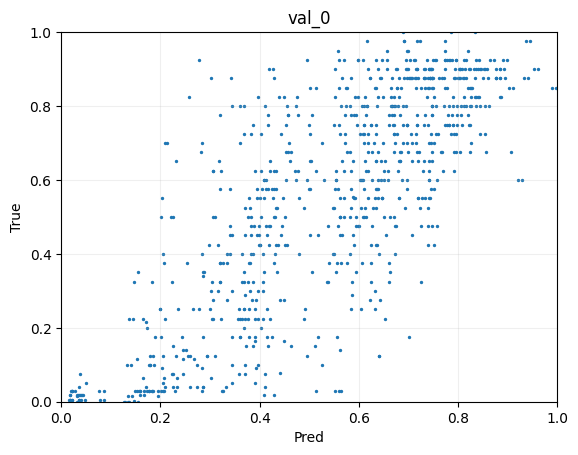

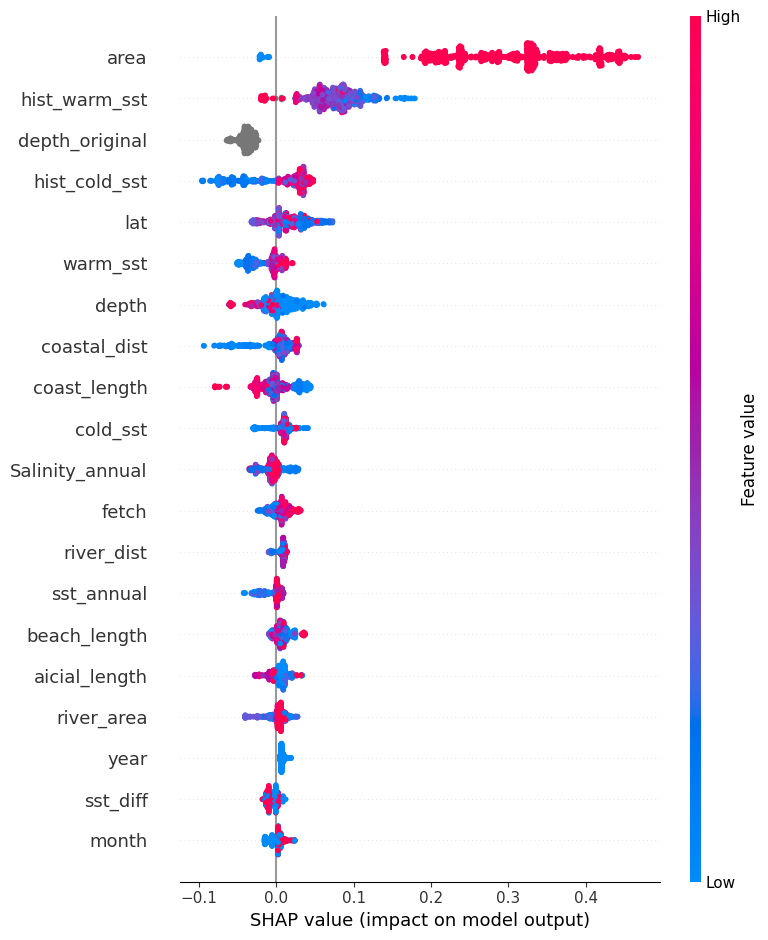

##############################
● CV1
##############################
[500]	valid_0's rmse: 0.1278
[1000]	valid_0's rmse: 0.124377
[1500]	valid_0's rmse: 0.122284
[2000]	valid_0's rmse: 0.121072
0.1724708408107188


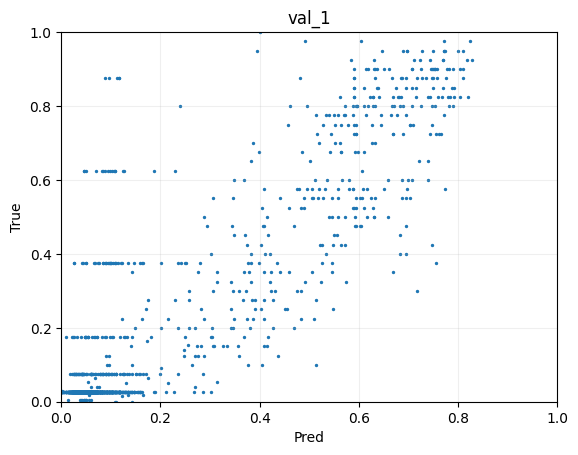

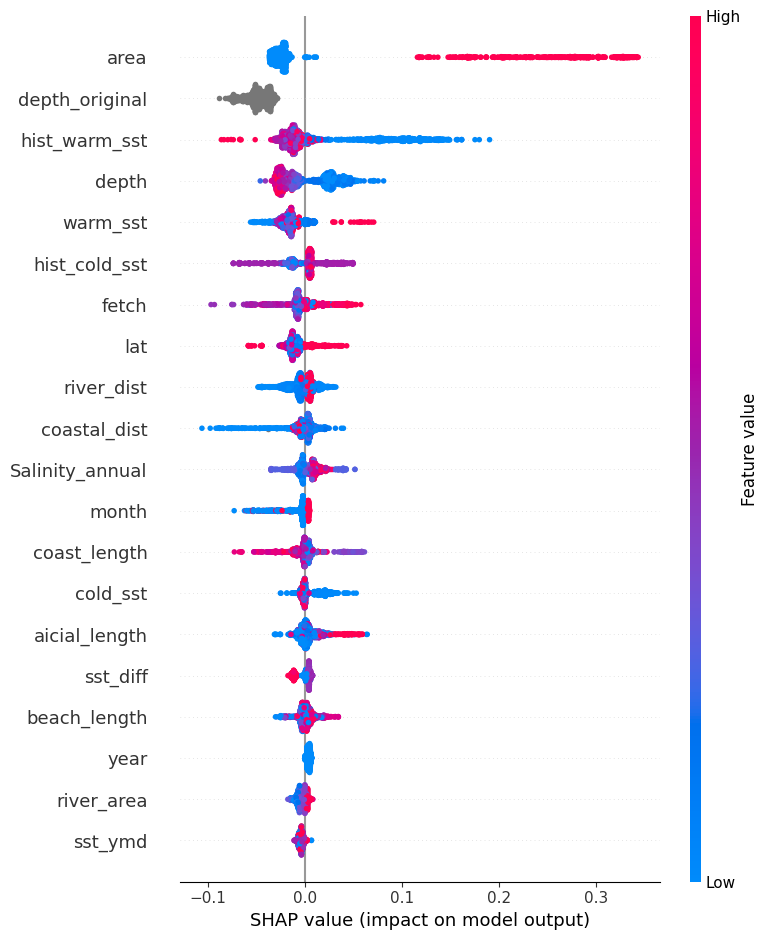

##############################
● CV2
##############################
[500]	valid_0's rmse: 0.0933649
[1000]	valid_0's rmse: 0.0955598
[1500]	valid_0's rmse: 0.0972995
[2000]	valid_0's rmse: 0.100639
0.0788903268797914


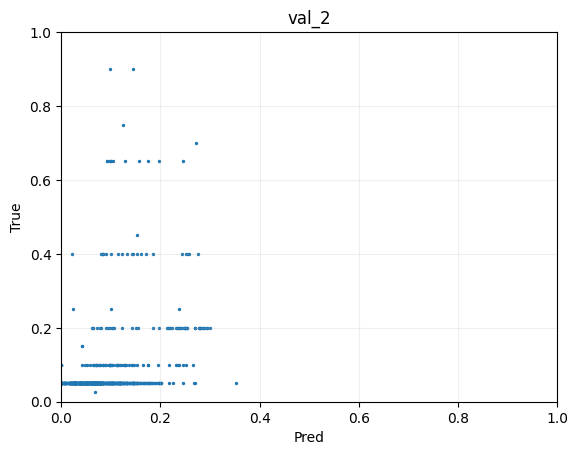

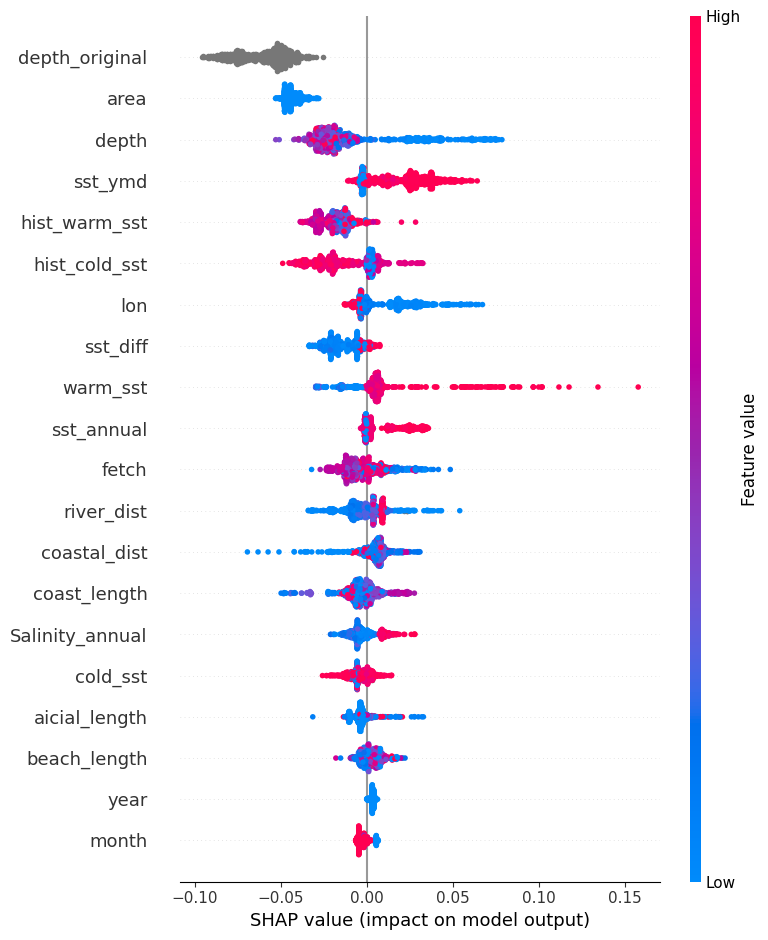

##############################
● CV3
##############################
[500]	valid_0's rmse: 0.136033
[1000]	valid_0's rmse: 0.137642
[1500]	valid_0's rmse: 0.142966
[2000]	valid_0's rmse: 0.151764
0.1847819829428915


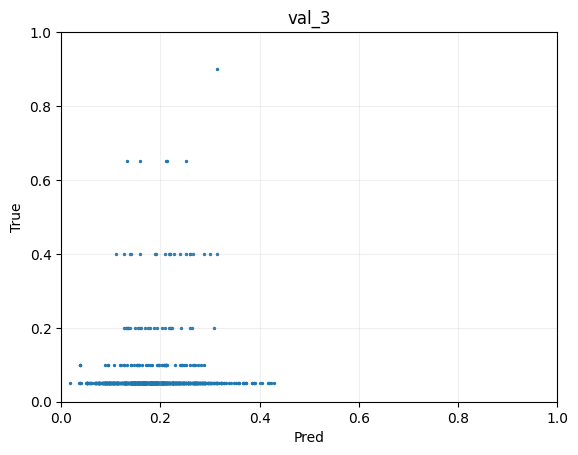

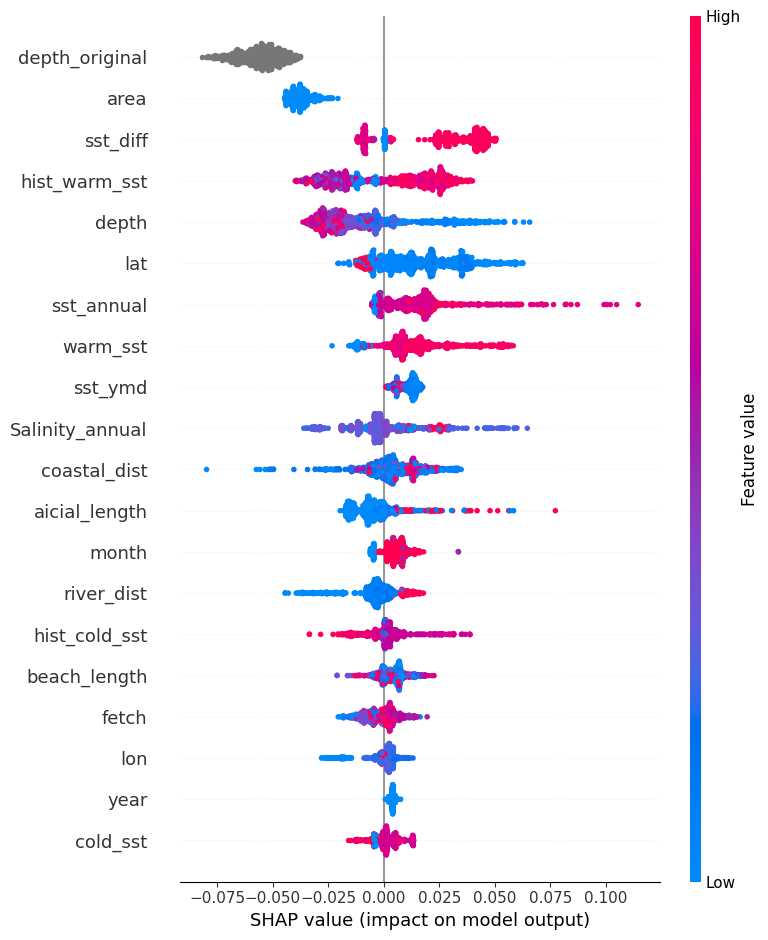

##############################
● CV4
##############################
[500]	valid_0's rmse: 0.216103
[1000]	valid_0's rmse: 0.22747
[1500]	valid_0's rmse: 0.226334
[2000]	valid_0's rmse: 0.227569
0.24666136997381372


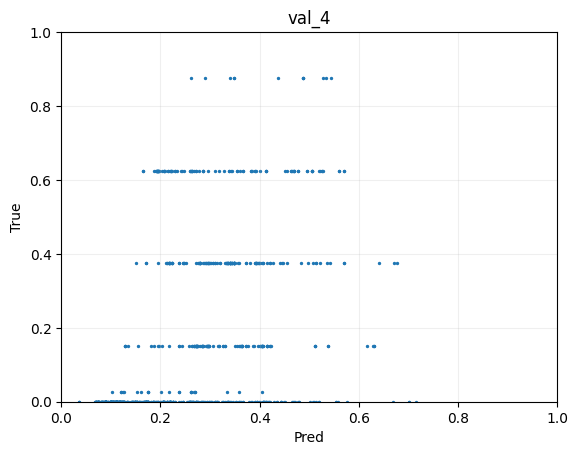

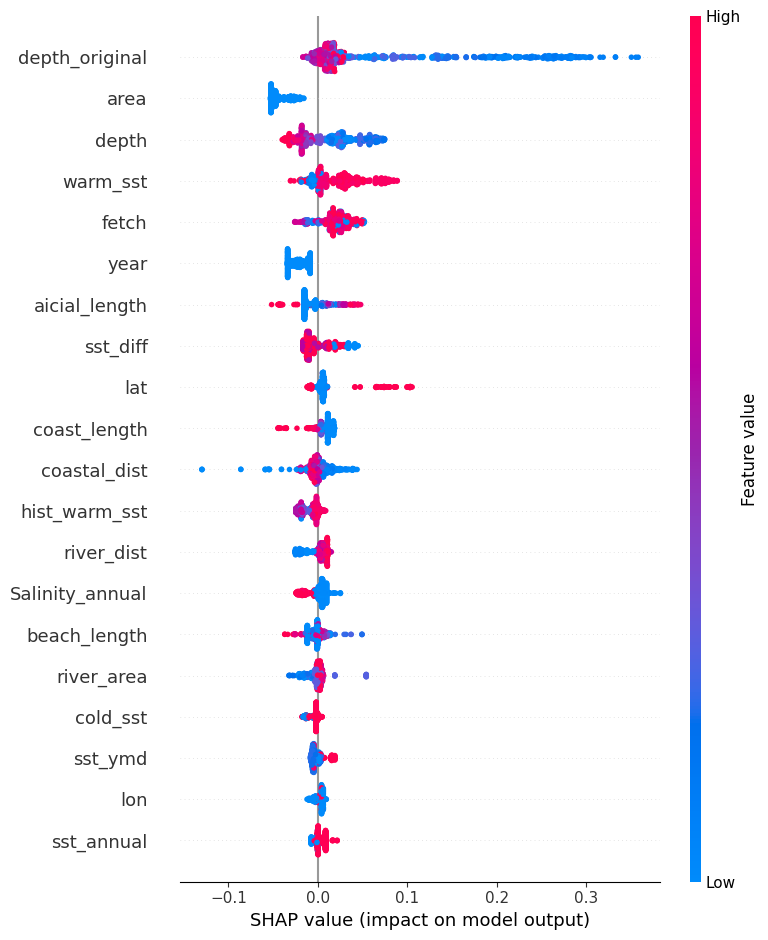

##############################
学習曲線
##############################


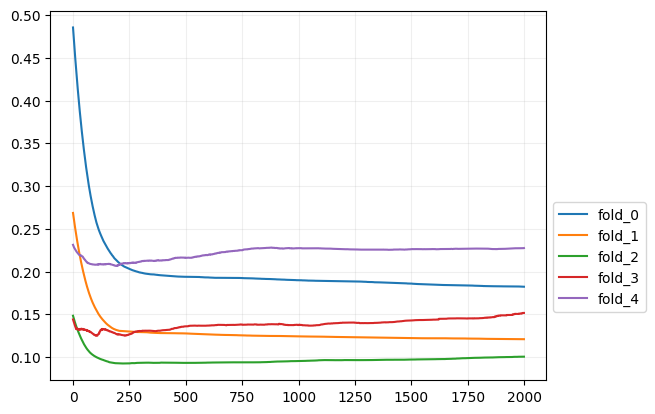

In [15]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'n_estimators': 2000,
    'learning_rate': 0.01,
    # 'num_leaves': 50,
    # 'colsample_bytree': 0.6,
    # 'subsample': 0.5,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 46,
}

results_rmse, fi_df, y_test_pred = my_cross_val_predict(train, test, y_name="cover", params=params, features=features, cv=cv)

CV0: 0.182
CV1: 0.121
CV2: 0.098
CV3: 0.152
CV4: 0.228
Average: 0.156


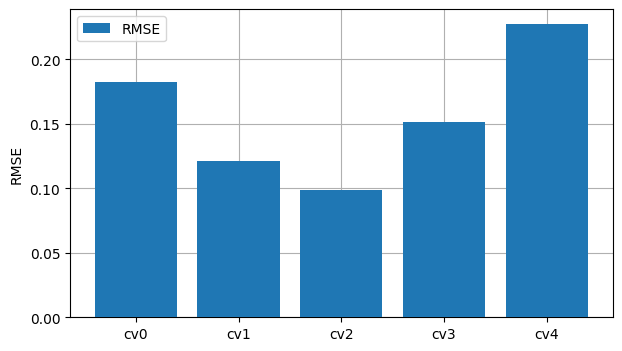

In [16]:
for i, rmse in enumerate(results_rmse):
    print(f"CV{i}: {rmse:.3f}")
print(f"Average: {np.average(results_rmse):.3f}")
plot_results(results_rmse)

(5, 23)


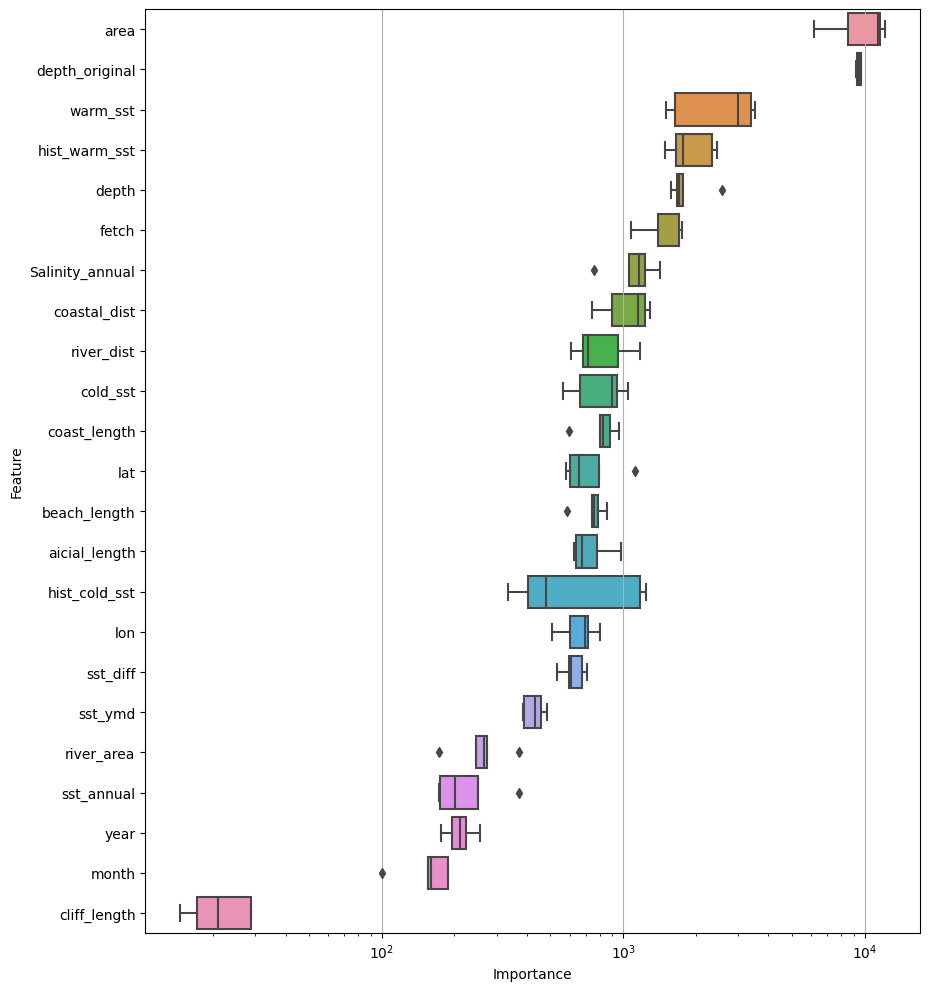

In [17]:
plot_importance(fi_df, figsize=(10, 12))

# Sub作成

In [18]:
test_sub = pd.DataFrame(y_test_pred, columns=["pred"])
test_sub

,pred
0,0.275425
1,0.048215
2,0.543363
3,0.046726
4,0.304094
...,...
4034,0.259682
4035,0.073680
4036,0.338486
4037,0.097868


In [19]:
test_pred_mean = test_sub["pred"].mean()
test_pred_mean

0.23814314397068373

In [20]:
public_mean = 0.09088
# test_sub["pred"] = test_sub["pred"] * (public_mean / test_pred_mean)
test_sub["pred"] -= (test_pred_mean - public_mean)
test_sub["pred"] = np.clip(test_sub["pred"].values, 0, 1)
test_sub

,pred
0,0.105108
1,0.018400
2,0.207358
3,0.017832
4,0.116048
...,...
4034,0.099100
4035,0.028118
4036,0.129173
4037,0.037348


In [21]:
print("pred_最小値:", test_sub["pred"].min())
print("pred_最大値:", test_sub["pred"].max())
print("pred_平均値:", test_sub["pred"].mean())

pred_最小値: 0.0
pred_最大値: 0.2882099068496689
pred_平均値: 0.09087999999999999


In [22]:
if SAVE_SUB:
    test_sub.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}.csv", header=False)